In [1]:
from scripts import support, insd, kuroda, nras, metrics, vectorization as v
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix
# np.set_printoptions(threshold=sys.maxsize)

In [2]:
df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "NAICS Codes", skiprows=4)
df = df.iloc[:-6,:-1]
df = df.dropna(axis=0, how = 'all')
df = df.fillna(0)
arr = np.array(df)

In [3]:
sectr = np.zeros(23)
sumsr = np.zeros(73)
secir = -1
sumsir = -1



for i in arr:
    
    
    if i[0] != 0 and i[1] != 0 and i[2] == 0 and i[3] == 0:
        secir = secir + 1
        
    if i[0] == 0 and i[1] != 0 and i[2] != 0 and i[3] == 0:
        sumsir = sumsir + 1
        
    if i[0] == 0 and i[1] == 0 and i[2] == 0 and i[3] != 0 and i[4] != 0 and i[5] != '**' and i[5] != '‡':
        sectr[secir]+=1
        sumsr[sumsir]+=1
        
        

sectc = np.zeros(23)
sumsc = np.zeros(73)
secic = -1
sumsic = -1



for i in arr:
    if i[0] != 0 and i[1] != 0 and i[2] == 0 and i[3] == 0:
        secic = secic + 1
        
    if i[0] == 0 and i[1] != 0 and i[2] != 0 and i[3] == 0:
        sumsic = sumsic + 1
        
    if i[0] == 0 and i[1] == 0 and i[2] == 0 and i[3] != 0 and i[4] != 0 and i[5] != '††':
        sectc[secic]+=1
        sumsc[sumsic]+=1
        
        
sumsc = sumsc[sumsc != 0]
sectc = sectc[sectc != 0]
sumsc[[51,52]] = sumsc[[52,51]]
sumsr[[51,52]] = sumsr[[52,51]]

In [4]:
sumsc[51]

3.0

In [5]:
def make_keym(big, smol, key):
    step = 0
    keym = np.zeros([smol, big])
    for k in range(len(key)):
        for i in range(int(key[k])):
            keym[k][step + i] = 1
        step += int(key[k])
    return keym

In [6]:
tr = make_keym(405, 73, sumsr)
tc = make_keym(405, 71, sumsc)

In [7]:
dff = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2007")
dff = dff.iloc[5:-11,2:-21]
dff = dff.fillna(0)
old = np.array(dff)
old[[402, 404]] = old[[404, 402]]
old[[401, 403]] = old[[403, 401]]

In [8]:
np.shape(dff)

(405, 405)

In [9]:
res = tr @ old @ tc.T

In [10]:
np.shape(res)

(73, 71)

In [11]:
tru = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2007")
tru = tru.iloc[6:-9,2:-21]
tru = tru.fillna(0)
truarr = np.array(tru)
truarr = np.where(truarr=='...', 0, truarr)
np.shape(truarr)

(73, 71)

In [12]:
metrics.get_values(res.astype(float), truarr.astype(float))

N0 2
PSISTAT 0.0
RSQ 1.0
MAPE 0.4025
SWAD 0.0
WAPE 0.0178


In [13]:
def keys_to_g(left, right):
    
    m = len(left)
    M = len(left[0])
    n = len(right)
    N = len(right[0])
    
    g = np.zeros([m*n, M*N])
    
    for i in range(n):
        for j in range(N):
            if right[i][j]:
                g[i*m:(i+1)*m, j*M:(j+1)*M] = left
                
    return g

In [14]:
g = keys_to_g(tr, tc)

In [15]:
g

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [16]:
a = v.tovector(old)
b = v.tovector(truarr)

In [17]:
ress = g @ a

In [18]:
metrics.get_values(ress.astype(float), b.astype(float))

N0 2
PSISTAT 0.0
RSQ 1.0
MAPE 0.4025
SWAD 0.0
WAPE 0.0178


In [19]:
bench = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2007")
bench = bench.iloc[5:-11,2:-21]
bench = bench.fillna(0)
bencharr = np.array(bench)
bencharr[[402, 404]] = bencharr[[404, 402]]
bencharr[[401, 403]] = bencharr[[403, 401]]
bencharr

array([[2687,  153,    8, ...,    0,    0,    0],
       [   0, 3113,    0, ...,    0,    0,    0],
       [   0,    0, 1151, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int64)

In [20]:
real12 = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2012")
real12 = real12.iloc[5:-11,2:-21]
real12 = real12.fillna(0)
real12arr = np.array(real12)
real12arr[[402, 404]] = real12arr[[404, 402]]
real12arr[[401, 403]] = real12arr[[403, 401]]
real12arr

array([[2507,  145,    4, ...,    0,    0,    0],
       [   0, 7731,    0, ...,    0,    0,    0],
       [   0,    0,  909, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int64)

In [21]:
# constr = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2012")
# constr = constr.iloc[6:-9,2:-21]
# constr = constr.fillna(0)
# constrarr = np.array(constr)
# constrarr = np.where(constrarr=='...', 0, constrarr).astype(float)
# constrarr

constrarr = tr @ real12arr @ tc.T
constrarr

array([[ 6.8986e+04,  8.4700e+02,  0.0000e+00, ...,  0.0000e+00,
         3.9650e+03,  0.0000e+00],
       [ 2.1846e+04,  5.9930e+03,  0.0000e+00, ...,  9.0000e+00,
         3.4450e+03,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  3.6344e+04, ...,  1.3770e+03,
         0.0000e+00,  2.0833e+04],
       ...,
       [ 0.0000e+00,  3.0000e+00,  0.0000e+00, ...,  2.3900e+02,
         3.8820e+03,  9.7500e+02],
       [ 9.3100e+02,  5.8000e+01,  1.1620e+03, ...,  1.0610e+03,
         0.0000e+00,  0.0000e+00],
       [-5.0000e+01,  4.0000e+01,  0.0000e+00, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00]])

In [22]:
benchv = v.tovector(bencharr).astype(float)
constrv = v.tovector(constrarr).astype(float)
real12v = v.tovector(real12arr).astype(float)

In [23]:
sum(constrv)

array([12989788.])

In [24]:
sums_rows = np.sum(real12arr, axis=1)[np.newaxis].T
sums_columns = np.sum(real12arr, axis=0)[np.newaxis].T

In [25]:
np.shape(sums_rows)

(405, 1)

In [26]:
my12nr = nras.nras(g, benchv, constrv, 0.01, 500)
my12in = insd.insd(g, benchv, constrv)

1
Academic license - for non-commercial use only
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



In [27]:
v.tomatrix(my12nr).astype(int)

array([[4048,  230,   12, ...,    0,    0,    0],
       [   0, 4689,    0, ...,    0,    0,    0],
       [   0,    0, 1734, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [28]:
my12in

-1

In [29]:
moreconstrv = np.append(constrv, sums_rows, axis=0)
moreconstrv = np.append(moreconstrv, sums_columns, axis=0)
np.shape(moreconstrv)

(5993, 1)

In [30]:
sg = csr_matrix(g)
mg = v.addrows((405,405), sg, sparsed=True)
mg = v.addcolumns((405,405), mg, sparsed=True)
np.shape(mg)

(5993, 164025)

In [31]:
np.shape(sg)

(5183, 164025)

In [32]:
mg.indices

array([     0,      1,      2, ..., 164022, 164023, 164024], dtype=int32)

In [33]:
mg

<5993x164025 sparse matrix of type '<class 'numpy.float64'>'
	with 492075 stored elements in Compressed Sparse Row format>

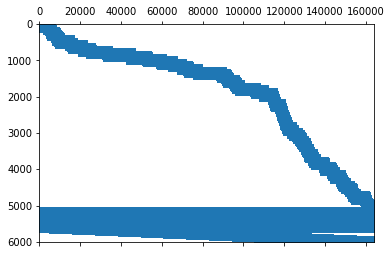

In [34]:
plt.spy(mg, aspect='auto')

In [35]:
np.shape(mg)

(5993, 164025)

In [36]:
np.shape(moreconstrv)

(5993, 1)

In [37]:
my12morenr = nras.nras(G=mg,aa= benchv, c=moreconstrv, accuracy=0.01,limit= 100, sparsed=True)

100


In [38]:
mg.toarray()

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [39]:
v.tomatrix(my12morenr).astype(int)

array([[3198,  168,    4, ...,    0,    0,    0],
       [   0, 8237,    0, ...,    0,    0,    0],
       [   0,    0, 1089, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [40]:
my12morein = insd.insd(G=mg, aa=benchv, c=moreconstrv, sparsed=True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



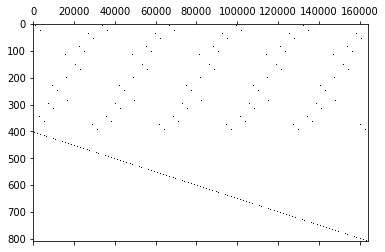

In [41]:
gg = v.addrows((405,405))
gg = v.addcolumns((405,405), gg)
plt.spy(gg, aspect='auto')

In [43]:
cc = np.append(sums_rows, sums_columns, axis=0)

In [56]:
tstnr = nras.nras(gg, benchv, cc, 0.01, 100)

67


In [57]:
v.tomatrix(tstnr).astype(int)

array([[3425,  182,    4, ...,    0,    0,    0],
       [   0, 9042,    0, ...,    0,    0,    0],
       [   0,    0, 1105, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [58]:
metrics.get_values(tstnr.astype(int), real12v.astype(int))

N0 2312
PSISTAT 0.0261
RSQ 0.9973
MAPE 12.0241
SWAD 0.9854
WAPE 19.5828


In [59]:
np.mean(abs(real12v - tstnr))

15.52217361148771

In [97]:
sum(real12v < 0)

array([15])

In [110]:
chiselka = min(benchv)# min(real12v))
chiselka = abs(chiselka)
mbenchv = benchv + chiselka
mcc = cc + chiselka * 405

In [111]:
tstin = insd.insd(gg, mbenchv, mcc)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


In [113]:
v.tomatrix(tstin).astype(int) - chiselka

array([[2894.,  237.,   19., ...,   40.,   46.,   52.],
       [ 113., 4270.,   94., ...,  123.,  129.,  136.],
       [  11.,   44., 1125., ...,   21.,   27.,   34.],
       ...,
       [   8.,   41.,  -11., ...,   18.,   24.,   31.],
       [  18.,   52.,    0., ...,   29.,   35.,   41.],
       [  49.,   82.,   30., ...,   59.,   65.,   72.]])

In [114]:
metrics.get_values(tstin.astype(int), real12v.astype(int))

N0 119117
PSISTAT 3.6918
RSQ 0.996
MAPE 2156.2038
SWAD -0.3392
WAPE 586.5144
